# Billiards in Φ<sub>Flow</sub>

This notebook reproduces the [billiards example](https://github.com/taichi-dev/difftaichi/blob/master/examples/billiards.py) described in the [DiffTaichi paper](https://arxiv.org/abs/1910.00935) using [Φ<sub>Flow</sub>](https://github.com/tum-pbs/PhiFlow).

In [ ]:
# !pip install phiflow

The import statement decides whether to use TensorFlow, PyTorch or Jax.

In [2]:
# from phi.tf.flow import *
from phi.torch.flow import *
# from phi.jax.stax.flow import *

First, we create the typical billiards triangle with four layers and a ball radius of 0.03.
We use the Φ<sub>Flow</sub> geometry class `Sphere` to represent the balls.

<Figure size 864x360 with 1 Axes>

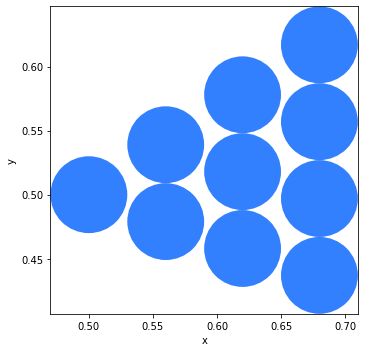

In [3]:
def billiards_triangle(billiard_layers=4, radius=.03):
    coords = []
    for i in range(billiard_layers):
        for j in range(i + 1):
            coords.append(vec(x=i * 2 * radius + 0.5, y=j * 2 * radius + 0.5 - i * radius * 0.7))
    return Sphere(stack(coords, instance('balls')), radius=radius)
  
plot(billiards_triangle())

Next, we define the dynamics consisting of linear movement and collisions with an elasticity of 0.8.
From here on, we will represent the system using a `phi.field.PointCloud` object storing the spheres and their velocities.
Below, we test the step with a simple pair collision.

In [14]:
def physics_step(v: PointCloud, dt: float, elasticity=0.8):
    v_next = advect.points(v, v, dt)
    dist = v_next.points - rename_dims(v_next.points, 'balls', 'others')
    dist_norm = math.vec_length(dist, eps=1e-4)  # eps to avoid NaN during backprop of sqrt
    rel_v = v.values - rename_dims(v.values, 'balls', 'others')
    dist_dir = math.divide_no_nan(dist, dist_norm)
    projected_v = dist_dir.vector * rel_v.vector
    has_impact = (projected_v < 0) & (dist_norm < 2 * v.elements.radius)
    impulse = -(1 + elasticity) * .5 * projected_v * dist_dir
    radius_sum = v.elements.radius + rename_dims(v.elements.radius, 'balls', 'others')
    impact_time = math.divide_no_nan(dist_norm - radius_sum, projected_v)
    x_inc_contrib = math.sum(math.where(has_impact, math.minimum(impact_time - dt, 0) * impulse, 0), 'others')
    v = v.with_elements(v.elements.shifted(x_inc_contrib))
    v += math.sum(math.where(has_impact, impulse, 0), 'others')
    return advect.points(v, v, dt)

# Simple animated test for physics_step
balls = Sphere(tensor([(0, .03), (.5, 0)], instance('balls'), channel(vector='x,y')), radius=.03)
ball_v = PointCloud(balls, tensor([(1., 0), (0, 0)], shape(balls)))
trj = iterate(physics_step, batch(t=20), ball_v, f_kwargs={'dt': .05})
plot(trj.elements, animate='t')

<Figure size 432x288 with 0 Axes>

Now, we can define our objective. We stick to the definition of the DiffTaichi paper, desiring the last ball in the triangle to reach the target position (x=0.9, y=0.75).
The loss function sets up our system consisting of the 10 balls in triangle formation plus the cue ball. The initial position and velocity of the cue ball is specified via the parameters `x0` and `v0`.
1024 time steps of the simulation are performed before the distance $L^2$ loss is computed and returned.

In [15]:
def loss_function(x0: Tensor, v0: Tensor, goal=vec(x=0.9, y=0.75), steps=1024):
    triangle_balls = PointCloud(billiards_triangle()) * (0, 0)
    controllable_ball = PointCloud(Sphere(expand(x0, instance(triangle_balls).with_size(1)), radius=triangle_balls.elements.radius)) * v0
    all_balls = controllable_ball & triangle_balls
    trj = iterate(physics_step, batch(t=steps), all_balls, f_kwargs={'dt': 0.003})
    return math.l2_loss(trj.t[-1].balls[-1] - goal), trj

Let's plot one simulated trajectory! We only show every 16th frame.

In [16]:
plot(loss_function(x0=vec(x=.1, y=.5), v0=vec(x=.3, y=0))[1].t[::16].elements, animate='t')

/usr/local/lib/python3.7/dist-packages/phi/field/_field_math.py:405: RuntimeWarning: concat() default implementation is slow on large dimensions (balls=11). Please implement __concat__()
  elements = geom.concat([f.elements for f in fields], dim, sizes=[f.shape.get_size(dim) for f in fields])
/usr/local/lib/python3.7/dist-packages/phi/field/_field_math.py:407: RuntimeWarning: concat() default implementation is slow on large dimensions (balls=11). Please implement __concat__()
  colors = math.concat([math.expand(f.color, f.shape.only(dim)) for f in fields], dim)


<Figure size 432x288 with 0 Axes>

Now, we can plot the loss landscape depending on the angle $\alpha$ of `v0`. We create a scan plot by sampling a `CenteredGrid` from a function.
The resulting plot matches Figure 11 from the [DiffTaichi paper](https://arxiv.org/pdf/1910.00935.pdf) with small deviations.
We noticed the loss landscape is highly dependent on the number of simulation steps.

/usr/local/lib/python3.7/dist-packages/phi/field/_field_math.py:405: RuntimeWarning: concat() default implementation is slow on large dimensions (balls=11). Please implement __concat__()
  elements = geom.concat([f.elements for f in fields], dim, sizes=[f.shape.get_size(dim) for f in fields])
/usr/local/lib/python3.7/dist-packages/phi/field/_field_math.py:407: RuntimeWarning: concat() default implementation is slow on large dimensions (balls=11). Please implement __concat__()
  colors = math.concat([math.expand(f.color, f.shape.only(dim)) for f in fields], dim)
/usr/local/lib/python3.7/dist-packages/phi/math/_magic_ops.py:101: RuntimeWarning: expand() default implementation is slow on large shapes (alphaᵇ=1000). Please implement __expand__()
  values = [expand(v, all_batch_dims) for v in values]


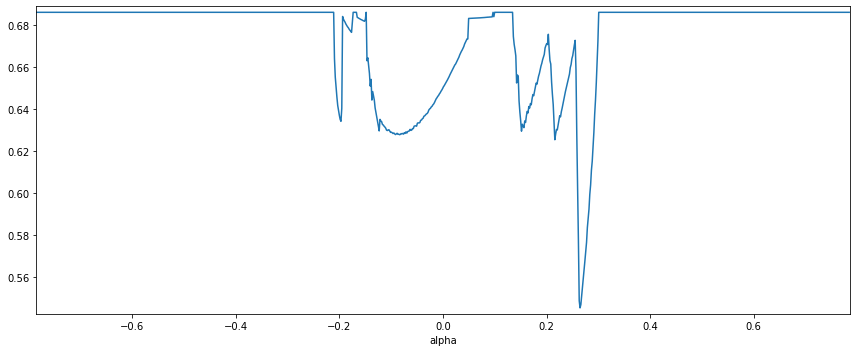

In [8]:
x0 = vec(x=.1, y=.5)
v0 = lambda alpha: vec(x=0.3 * math.cos(alpha), y=0.3 * math.sin(alpha))
plot(CenteredGrid(lambda alpha: loss_function(x0, v0(alpha))[0], alpha=1000, bounds=Box(alpha=(-PI/4, PI/4))))

Next, we perform simple gradient descent optimization on the loss landscape.
However, due to the chaotic loss landscape, this performs rather poorly.
We plot the found trajectory after 5 iterations along with the goal point (X).

In [ ]:
loss_grad = math.functional_gradient(loss_function, 'x0,v0')
x0 = vec(x=.1, y=.5)
v0 = vec(x=.3, y=0)
learning_rate = .01
for iter in range(5):
    (loss, trj), (dx0, dv0) = loss_grad(x0, v0)
    print(f"Iter={iter}  loss={loss:.3f}  x0={x0}  ∇={dx0}  v0={v0}  ∇={dv0}")
    x0 -= learning_rate * dx0
    v0 -= learning_rate * dv0
final_loss, trj = loss_function(x0, v0)
print(f"Final loss: {final_loss}")
plot(vis.overlay(trj.t[::16].elements, vec(x=0.9, y=0.75)), animate='t')

Iter=0  loss=0.6501343  x0=(x=0.100, y=0.500) float64  ∇=(x=-0.654, y=1.529)  v0=(x=0.300, y=0.000)  ∇=(x=-0.889, y=1.734)
